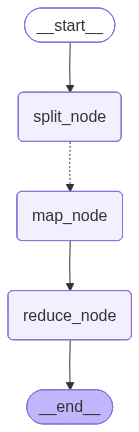

Final state: {'large_input_data': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'intermediate_results': [55, 155, 255, 355, 455, 555, 655, 755, 855, 955], 'final_result': 5050}
Final result: 5050


In [ ]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import Image, display


def split_large_data(data, num_sub_tasks: int = 10):
    chunk_size = max(1, len(data) // num_sub_tasks)
    return [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

def process_sub_data(sub_data):
    return sum(sub_data)

def aggregate_results(intermediate_results):
    return sum(intermediate_results)
 
# 全流程共享, 所有节点可访问
class OverallState(TypedDict):
    large_input_data: Any
    intermediate_results: Annotated[list, operator.add]
    final_result: Any


def split_input_data(state: OverallState):
    input_data = state["large_input_data"]
    sub_datasets = split_large_data(input_data, num_sub_tasks=10)
    send_list = [Send("map_node", {"sub_data": sub_dataset}) for sub_dataset in sub_datasets]
    return {"send": send_list}


class MapState(TypedDict):
    sub_data: Any


def map_node(state: MapState):
    sub_data = state["sub_data"]
    intermediate_result = process_sub_data(sub_data)
    # ✅ 返回 dict[str, list] 以支持 operator.add 聚合
    return {"intermediate_results": [intermediate_result]}


class ReduceState(TypedDict):
    intermediate_results: Annotated[list, operator.add]


def reduce_node(state: ReduceState):
    intermediate_results = state["intermediate_results"]
    final_result = aggregate_results(intermediate_results)
    return {"final_result": final_result}


def build_graph():
    graph = StateGraph(OverallState)

    graph.add_node("split_node", split_input_data)
    graph.add_node("map_node", map_node)
    graph.add_node("reduce_node", reduce_node)

    # START 是固定的入口节点
    graph.add_edge(START, "split_node")
    graph.add_edge("map_node", "reduce_node")
    graph.add_edge("reduce_node", END)

    graph.add_conditional_edges(
        "split_node",
        lambda state: state["send"],
        ["map_node"],
    ) # 分割节点 -》 映射节点（条件边）

    return graph.compile()


workflow = build_graph()

display(Image(workflow.get_graph().draw_mermaid_png()))

input_data = list(range(1, 101))
final_state = workflow.invoke({"large_input_data": input_data})

print("Final state:", final_state)
print("Final result:", final_state["final_result"])